# Exercise 07: Dimensionality reduction and clustering

Welcome to the seventh exercise for Applied Machine Learning. 

Your objectives for this session are to: 
- implement dimensionality reduction with `PCA`, 
- interpret the outputs of `PCA`,
- perform clustering with `KMeans`, and 
- evaluate the results clusters with a variety of metrics.

---------------------

### Part 1: Data prepartion

In this exercise, we'll work with real-worold football data sourced from [FBref](https://fbref.com/en/).

Each row represents a player and we have 117(!) statistics on each player, such as `Ast/90` (number of assists per 90 minutes), `Shots/90` (number of shots per 90 minutes), and `Att 3rdTchs/90` (the number of touches a player makes in the attacking third of the pitch per 90 minutes). The dataset covers the 2017-18 season and includes all players from the top five leagues. 

In football, players are often categorized by their position: Are you a goalkeeper, defender, midfielder, or forward? But, categorizing players doesn't fully describe the tactical role a player plays for their team. For example, both Lionel Messi and Erling Haaland play as a forward, but they have very distinct skillsets; both N'Golo Kanté and Martin Ødegaard are midfielders, but Kanté is a much more defensive-minded player than Ødegaard. 

Taking inspiration from [this 2022 article in The Athletic](https://www.nytimes.com/athletic/3473297/2022/08/10/player-roles-the-athletic/), let's use unsupervised machine learning to explore differences in playing style across individual players and positions... 

Let's start by importing our libraries.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt

Now read in the data.

In [2]:
data = pd.read_csv("footballers.csv")

Use the code below to do some basic preprocessing.

In [3]:
# change "Min" column to numeric by removing commas and converting to integer
data["Min"] = data["Min"].apply(lambda x: x.replace(",", "")).astype(int)

# filter the data so we keep only players who have played >500 minutes
data = data.loc[data["Min"] > 500]

# reset the df index after filtering
data = data.reset_index(drop=True)

# convert stats columns to numeric: with errors='coerce' turning non-convertible values into NaN
# & replace NaNs with 0s using fillna(0)
data.iloc[:, 11:] = data.iloc[:, 11:].apply(pd.to_numeric, errors='coerce').fillna(0)

# define feature matrix X — a matrix with all the stats we'll use for analysis
X = data.iloc[:, 11:]

Inspect the head and shape of feature matrix `X`. Notice that we have features with varying scales. For example, some stats are "per 90 minutes" (e.g., `Ast/90`) and other stats are percentages (e.g., `SoT%`, percentage of shots on target).

In [4]:
X.head()

,Ast/90,npG/90,npG+A/90,xA/90,npxG/90,npxG+xA/90,Shots/90,SoTs/90,SoT%,Gls/Shot,...,PrgDistCarry/90,ProgCarry/90,CarryIntoThird/90,CarryIntoBox/90,Miscontrol/90,Dispossessed/90,PassTarget/90,PassesReceived/90,PassRec%,ProgPassReceived/90
0,0.05,0.00,0.05,0.04,0.06,0.10,0.91,0.30,33.3,0.00,...,96.8,5.79,1.52,0.46,0.66,0.81,42.3,39.3,92.8,2.34
1,0.00,0.09,0.09,0.01,0.05,0.06,0.47,0.16,33.3,0.20,...,130.5,1.81,0.25,0.03,0.25,0.47,43.8,42.5,97.0,0.22
2,0.00,0.00,0.00,0.00,0.08,0.09,0.93,0.21,23.1,0.00,...,117.9,1.14,0.07,0.00,0.14,0.07,33.7,32.9,97.7,0.00
3,0.00,0.07,0.07,0.03,0.05,0.08,0.66,0.15,22.2,0.11,...,92.7,3.24,0.66,0.00,0.22,0.00,34.8,33.4,96.0,0.59
4,0.03,0.00,0.03,0.03,0.03,0.06,0.26,0.00,0.0,0.00,...,166.3,3.71,1.02,0.03,0.45,0.26,50.9,49.5,97.3,0.70


In [5]:
X.shape

(1959, 117)

### Part 2: Dimensionality reduction with `PCA`

We have 1959 rows (players) and 117 columns (stats). To get a sense of the data, we could try to visualize it, but visualizing 117 dimensions at once is impossible. So, let's first use `PCA` to reduce the dimensionality to just 2 dimensions and plot it.

# <font color='red'>TASK 1</font>

`PCA` can be affected by varying scales, so we first need to standardize the data. Use `StandardScaler` to standardize the data, creating a new feature matrix called `X_scaled`.

In [6]:
# your code here
X_scaled = StandardScaler().fit_transform(X)

Now that we have `X_scaled`, use the code below to apply `PCA` to the scaled data. Notice how we specify that there should be only 2 principal components, since we want to visualize the data in 2D.

In [7]:
# Apply PCA to reduce to 2 components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

Inspect the shape of `X_pca`. Notice how we still have a row for each of the 1959 players, but now we have only 2 columns (i.e., 2 principal components).

In [8]:
X_pca.shape

(1959, 2)

Use the code below to create a PCA plot of the data, where each point (player) is colored by their designated position. Some players have more than one designated position (e.g., Lionel Messi is `FW,MF` because he's played as a forward and midfielder). 

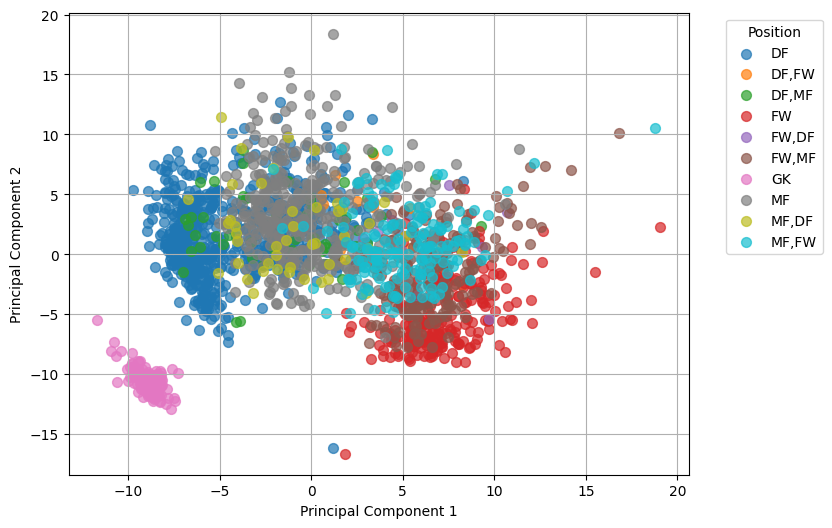

In [9]:
# Extract the 'Pos' column (position)
positions = data['Pos']

# Plot the PCA results, coloring by position
unique_positions = positions.unique()
position_colors = {pos: plt.cm.tab10(i/len(unique_positions)) for i, pos in enumerate(unique_positions)}

plt.figure(figsize=(8, 6))
for pos in unique_positions:
    idx = positions == pos
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1], label=pos, color=position_colors[pos], alpha=0.7, s=50)

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title='Position', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

Use the code below to print the top 10 loadings for PC1 and PC2.

In [10]:
# PCA loadings 
loadings = pca.components_

# Assuming X is a DataFrame, we can extract the feature names
feature_names = X.columns

# Create a DataFrame with loadings for each component and feature
loadings_df = pd.DataFrame(loadings.T, index=feature_names, columns=['PC1', 'PC2'])

# Calculate absolute loadings
abs_loadings_df = loadings_df.abs()

# Get top 10 absolute loadings for each principal component
top_10_PC1 = abs_loadings_df['PC1'].nlargest(10)
top_10_PC2 = abs_loadings_df['PC2'].nlargest(10)

# Print the top 10 loadings for PC1 and PC2
print("Top 10 absolute loadings for PC1:")
print(loadings_df.loc[top_10_PC1.index].sort_values(by='PC1', ascending=False))

print("\nTop 10 absolute loadings for PC2:")
print(loadings_df.loc[top_10_PC2.index].sort_values(by='PC2', ascending=False))

Top 10 absolute loadings for PC1:
                          PC1       PC2
%TchsAttThrd         0.170355 -0.004561
ProgPassReceived/90  0.164137 -0.023880
Att PenTchs/90       0.155574 -0.029647
npxG+xA/90           0.155331 -0.014866
Att 3rdPress/90      0.153871 -0.019264
Miscontrol/90        0.153714 -0.031007
Shots/90             0.150639 -0.015821
Att 3rdTchs/90       0.148805  0.069646
%TchsDefThrd        -0.152217 -0.064354
Def 3rdTchs/90      -0.162212  0.019060

Top 10 absolute loadings for PC2:
                        PC1       PC2
Mid 3rdTchs/90    -0.016045  0.185325
LiveTchs/90       -0.038413  0.184200
Touches/90        -0.048928  0.182810
Carries/90        -0.008134  0.179741
PassesReceived/90 -0.007205  0.175171
LivePassAtt/90    -0.060112  0.174266
ProgPass/90        0.022869  0.172776
PassAtt/90        -0.068962  0.170468
ShortCmp/90        0.019881  0.167520
ShortAtt/90        0.035792  0.167133


# <font color='red'>TASK 2</font>

Look back over the PCA plot and the loadings above. How do you interpret this? What stats seem to explain differences between players of different positions?

Discuss with a classmate.

In the above, we specified that `PCA` should reduce the number of dimensions down to exactly 2 principal components, because we specifically wanted to make a 2D plot. But, it could be that just 2 principal components doesn't really capture the overall variance of the original data. 

# <font color='red'>TASK 3</font>

Re-apply `PCA` to `X_scaled` without restricting `n_components`. Call the new feature matrix `X_pca_full`.

In [18]:
# your code here - refit pca without constraining the number of dimensions
pca_full = PCA()
X_pca_full = pca_full.fit_transform(X_scaled)

Use the code below to visualize the variance captured across principal components.

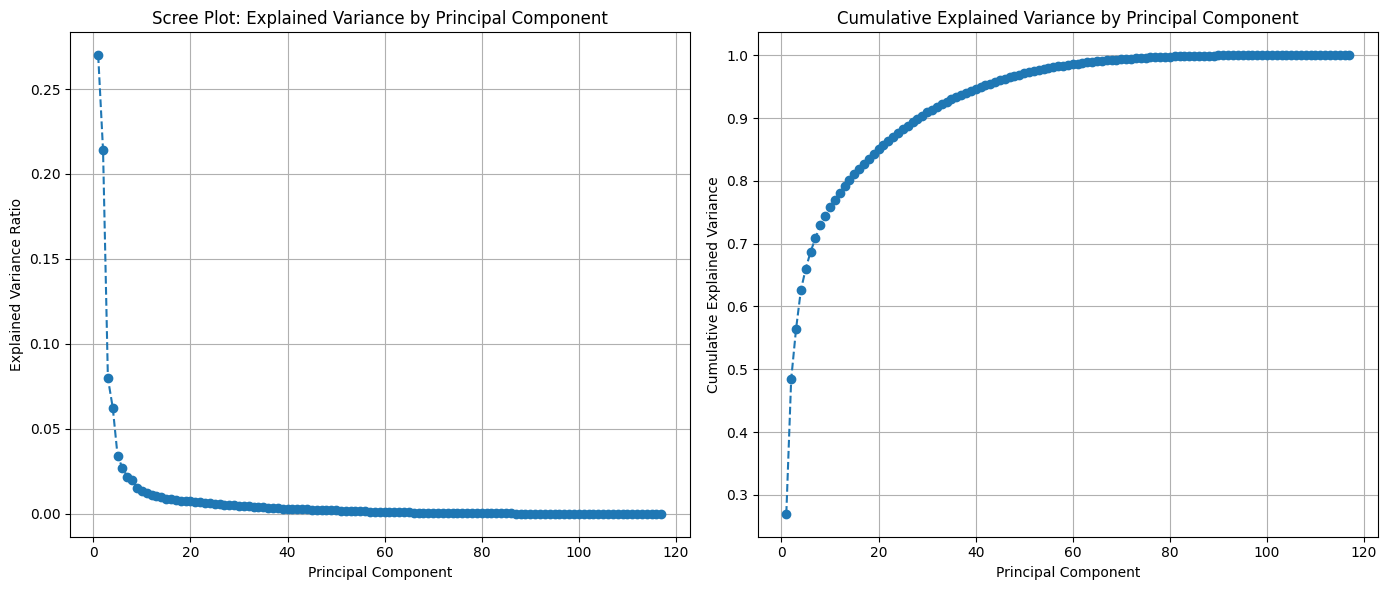

In [20]:
# calculate cumulative explained variance
cumulative_explained_variance = pca_full.explained_variance_ratio_.cumsum()

# create a figure space with two panels
plt.figure(figsize=(14, 6))

# scree plot (explained variance by component)
plt.subplot(1, 2, 1)
plt.plot(range(1, len(pca_full.explained_variance_ratio_) + 1), 
         pca_full.explained_variance_ratio_, marker='o', linestyle='--')
plt.title("Scree Plot: Explained Variance by Principal Component")
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.grid(True)

# cumulative explained variance plot
plt.subplot(1, 2, 2)
plt.plot(range(1, len(cumulative_explained_variance) + 1), 
         cumulative_explained_variance, marker='o', linestyle='--')
plt.title("Cumulative Explained Variance by Principal Component")
plt.xlabel("Principal Component")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True)

# Show the plots
plt.tight_layout()
plt.show()

# <font color='red'>TASK 4</font>

How do you interpret the plots above? For example, if you want to reduce dimensionality and still capture 95% of the variance in the original data, approximately how many principal components should you keep?

### Part 3: `KMeans` clustering and evaluation

Now that we've explored the data with `PCA`, lets apply an unsupervised clustering algorithm, `KMeans`, and see what kind of player profiles it identifies. Will the clusters we identify align to traditional, position-based player categories? Or, will we discover new profiles that trascend the traditional, position-based categories?

# <font color='red'>TASK 5</font>

Initialize the `KMeans` clustering algorithm. Call it `kmeans`, and specify `n_clusters=4` on this first attempt, since there are traditionally four positions: goalkeeper, defender, midfielder, and forward. 

Then, fit `kmeans` to the scaled data, `X_scaled`. 

In [ ]:
# your code here - apply KMeans clustering



Use the code below to visualize the clusters identified by `kmeans` with a 2D PCA plot.

In [ ]:
cluster_labels = kmeans.labels_

# create a scatter plot of the PCA results, coloring by KMeans clusters
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis', s=50, alpha=0.7)

# add labels and titles
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.show()


In the plot above, we can see that `kmeans` has identified four clusters that roughly map onto the traditional, position-based player profiles. But remember: `n_clusters` (number of clusters) is a hyperparameter. The `KMeans` algorithm will identify whatever number of clusters we tell it to identify. To figure out what the best setting for `n_clusters` is, we can try different settings and see how it affects different clustering evaluation metrics like *inertia* or the *silhouette score*.

# <font color='red'>TASK 5</font>

Write a loop that applies `KMeans` to `X_scaled` with different settings of `n_clusters` (try all values from 2-10) and stores the resulting inertia values in a list called `inertias`. 

*Hint: The syntax for retrieving a single inertia value is `kmeans.inertia_` (i.e., `inertia_` is an attribute of a fitted `KMeans` estimator).*

In [ ]:
# your code here 

# <font color='red'>TASK 6</font>

Write a loop that applies `KMeans` to `X_scaled` with different settings of `n_clusters` (try all values from 2-10), and calculates and stores the resulting silhouette scores in a list called `silhouettes`.  

*Hint: The syntax for retrieving a single silhouette score is `silhouette_score(X_scaled, kmeans.labels_)`.*

In [ ]:
# your code here 

# <font color='red'>TASK 7</font>

Write a loop that applies `KMeans` to `X_scaled` with different settings of `n_clusters` (try all values from 2-10), and calculates and stores the resulting Davies-Bouldin indices in a list called `daviesbouldins`.

*Hint: The syntax for retrieving a single Davies-Bouldin index is `davies_bouldin_score(X_scaled, kmeans.labels_)`.*

In [ ]:
# your code here

Use the code below to plot the different metrics you just calculated by the corresponding setting for `n_clusters`.

In [ ]:
# Create a figure with three subplots side by side
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

# Elbow plot for inertias
ax1.plot(cluster_range, inertias, marker='o', linestyle='-', color='b')
ax1.set_title('Elbow Plot (Inertias)')
ax1.set_xlabel('Number of Clusters')
ax1.set_ylabel('Inertia')

# Silhouette scores plot
ax2.plot(cluster_range, silhouettes, marker='o', linestyle='-', color='r')
ax2.set_title('Silhouette Scores')
ax2.set_xlabel('Number of Clusters')
ax2.set_ylabel('Silhouette Score')

# Davies-Bouldin Index plot
ax3.plot(cluster_range, daviesbouldins, marker='o', linestyle='-', color='g')
ax3.set_title('Davies-Bouldin Index')
ax3.set_xlabel('Number of Clusters')
ax3.set_ylabel('Davies-Bouldin Index')

# Show the plot
plt.tight_layout()
plt.show()

Based on the plot above, what do you think is the appropriate number of clusters? 

The plot showing the inertias on the far left has no clear "elbow" to enable one to use the elbow method to set `n_clusters`. Based on the inertias, one could argue that there should be 3, 4, 5, or maybe even 6 clusters... it's subjective!

Looking at the silhouette scores and the Davies-Bouldin indices, it seems clear that `n_clusters=3` is the suggested setting. But with our domain knowledge of football, we know that there are more than 3 positions. Perhaps our clustering analysis is suggesting that, based on in-game stats, it's more accurate to categorize players simply as goalkeepers, defenders, and attackers. It's hard to know for sure!

If we were to continue on with this analysis in practice, it would be wise to try scaling our data in different ways, to apply a variety of different clustering algorithms, and to try clustering different subsets of the data. But still, interpreting the outputs of unsupervised machine learning often boils down to a subjective assessment of what makes sense based on what you — the analyst — is trying to learn.

---------
**That's it for this week! Next week we'll shift focus and see how to evaluate classification and regression models.**